<a href="https://colab.research.google.com/github/nkharlamova/ML/blob/main/!HW_17_text_classification_spaCy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TASK: Perform reviews' classification into positive and negative. Use spaCy.**

**Dataset: https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews**

In [ ]:
import pandas as pd
import numpy as np
import spacy
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS
import re
import string
from tqdm import tqdm
from scipy.sparse import hstack

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loading the dataset.**

In [ ]:
# Завантажимо наш датасет
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IMDB Dataset.csv")

**Removing the tags.**

In [ ]:
# Видалимо теги
df["review"] = df["review"].str.replace("<br /><br />", "")

**Loading the spaCy model.**

In [ ]:
# Завантажимо модель spaCy
nlp = en_core_web_sm.load()

**Creating a text preprocessing function.**

In [ ]:
# Створюємо функцію попередньої обробки тексту
def preprocess_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    doc = nlp(text)
    processed_tokens = []
    for token in doc:
        if token.is_space:
            processed_tokens.append(token.text)
        elif not token.is_stop:
            processed_tokens.append(f"{token.lemma_}_{token.pos_}")

    return ' '.join(processed_tokens)

**For processing control:**

In [ ]:
# Для контролю обробки
tqdm.pandas()

**Text preprocessing.**

In [ ]:
# Робимо попередню обробку текста
df["processed_review"] = df["review"].progress_apply(preprocess_text)

100%|██████████| 50000/50000 [39:25<00:00, 21.13it/s]


**Let's take a look at the POS distribution after text preprocessing.**

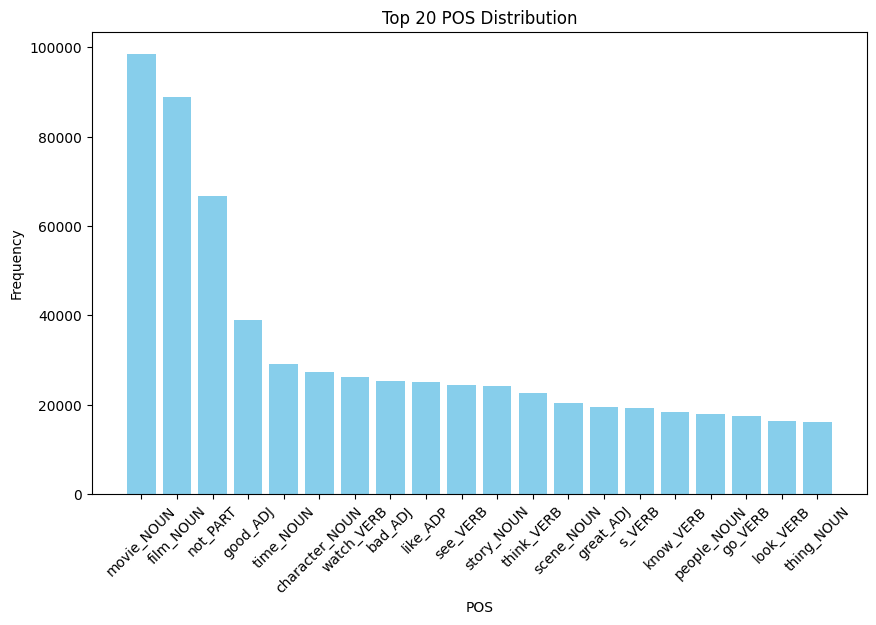

In [ ]:
# Подивимося на POS розподіл після обробки тексту
all_pos = ' '.join(df["processed_review"]).split()
all_pos_counts = Counter(all_pos)
sorted_all_pos_counts = dict(sorted(all_pos_counts.items(), key=lambda item: item[1], reverse=True))
top_20_pos = dict(list(sorted_all_pos_counts.items())[:20])

plt.figure(figsize=(10, 6))
plt.bar(top_20_pos.keys(), top_20_pos.values(), color="skyblue")
plt.title("Top 20 POS Distribution")
plt.xlabel("POS")
plt.ylabel("Frequency")
plt.xticks(rotation=45)

plt.show()

**Interestingly, adjectives that would primarily influence classification have the smallest count compared to other parts of speech. Nevertheless, we still see the most important ones: "good," "bad," and "great." It can be added that besides the main keywords "movie" and "film," the picture slightly differs from what we saw in the previous assignment without using spaCy, meaning even the detection of key words depends on the type of preprocessing done beforehand.**

In [ ]:
# Цікаво, що прикметників, які в першу чергу мали б впливати на класфікацію, найменша кількість, в порівнянні з іншими частинами мови.
# Але все ж бачимо найважливіші: good, bad та great
# Можна додати, що окрім головних ключових слів movie та film, картина трохи відрізняється від тої,
# що ми бачили в попередньому ДЗ без використання spaCy, тобто виявлення навіть ключових слів залежить від типу попередньої обробки


**Converting classes to numbers.**

In [ ]:
# Йдемо далі, переводимо класи в числа
df["sentiment"] = df["sentiment"].map({"positive": 1, "negative": 0})

**Adding a new feature - text length.**

In [ ]:
# Додаємо фічу - довжина тексту
df["text_length"] = df["review"].apply(lambda x: len(x))

**Let's add another feature - the average word length in a string.**

In [ ]:
# Додамо ще одну фічу - середню довжину слів у рядку
def average_word_length(row):
    words = row.split()
    word_lengths = [len(word) for word in words]
    return np.mean(word_lengths)

df["average_word_length"] = df["review"].apply(average_word_length)

**Let's see what we have got.**

In [ ]:
# Подивимось, що в нас вийшло
df.head()

,review,sentiment,processed_review,text_length,average_word_length
0,One of the other reviewers has mentioned that ...,1,reviewer_NOUN mention_VERB watch_VERB oz_NOU...,1725,4.734219
1,A wonderful little production. The filming tec...,1,wonderful_ADJ little_ADJ production_NOUN film_...,962,5.173077
2,I thought this was a wonderful way to spend ti...,1,think_VERB wonderful_ADJ way_NOUN spend_VERB t...,902,4.574074
3,Basically there's a family where a little boy ...,0,basically_ADV s_VERB family_NOUN little_ADJ bo...,712,4.401515
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter_PROPN matteis_PROPN love_NOUN time_NOUN...,1269,4.720721


**Splitting the dataset into features and target variables.**

In [ ]:
# Розділяємо датасет на ознаки та цільову змінну
X = df[["processed_review", "text_length", "average_word_length"]]
y = df["sentiment"]

**Scaling of the numerical features.**

In [ ]:
# Застосовуємо скалер до числових ознак
scaler = StandardScaler()
X_scaled = X.copy()
columns_to_scale = ["text_length", "average_word_length"]
X_scaled.loc[:, columns_to_scale] = scaler.fit_transform(X_scaled[columns_to_scale])

**Splitting the dataset into training, validation, and test samples.**

In [ ]:
# Розділяємо датасет на тренувальну, тестову та валідаційну частини
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

**Vectorization of the textual variable.**

In [ ]:
# Робимо векторизацію текстової змінної
vectorizer = TfidfVectorizer(max_features=10000)
X_train_text = vectorizer.fit_transform(X_train["processed_review"])
X_test_text = vectorizer.transform(X_test["processed_review"])
X_val_text = vectorizer.transform(X_val["processed_review"])

**Combining textual and numerical features across all samples.**

In [ ]:
# З'єднуємо текстову та числові ознаки на всих наборах даних
X_train_combined = hstack((X_train_text, X_train[["text_length"]].values, X_train[["average_word_length"]].values))
X_test_combined = hstack((X_test_text, X_test[["text_length"]].values, X_test[["average_word_length"]].values))
X_val_combined = hstack((X_val_text, X_val[["text_length"]].values, X_val[["average_word_length"]].values))

**Let's try the Linear SVM model.**

In [ ]:
# Спробуємо модель Linear SVM
svm_model = LinearSVC(max_iter=10000)
svm_model.fit(X_train_combined, y_train)

LinearSVC(max_iter=10000)

**Calculating the evaluation of the LinearSVC model on the training and test samples.**

In [ ]:
# Розраховуємо оцінку на тренувальній та тестовій вибірці:
train_score_svm = svm_model.score(X_train_combined, y_train)
test_score_svm = svm_model.score(X_test_combined, y_test)
print("Train Score LinearSVC:", train_score_svm)
print("Test Score LinearSVC:", test_score_svm)

Train Score LinearSVC: 0.9554571428571429
Test Score LinearSVC: 0.8785333333333334


**Evaluation of the LinearSVC model.**

In [ ]:
# Дивимось оцінку моделі Linear SVC
y_pred_svm = svm_model.predict(X_test_combined)
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      3722
           1       0.87      0.89      0.88      3778

    accuracy                           0.88      7500
   macro avg       0.88      0.88      0.88      7500
weighted avg       0.88      0.88      0.88      7500



**Let's also try the LogisticRegression model.**

In [ ]:
# Пробуємо тепер модель LogisticRegression
lr_model = LogisticRegression(max_iter=5000, random_state=42)
lr_model.fit(X_train_combined, y_train)

LogisticRegression(max_iter=5000, random_state=42)

**Calculating the evaluation of the LogisticRegression model on the training and test samples.**

In [ ]:
# Розраховуємо оцінки на тренувальній та тестовій вибірці:
train_score_lr = lr_model.score(X_train_combined, y_train)
test_score_lr = lr_model.score(X_test_combined, y_test)
print("Train Score Logistic Regression:", train_score_lr)
print("Test Score Logistic Regression:", test_score_lr)

Train Score Logistic Regression: 0.9151428571428571
Test Score Logistic Regression: 0.8862666666666666


**Evaluation of the LogisticRegression model.**

In [ ]:
# Дивимось оцінку моделі LogisticRegression
y_pred_logistic = lr_model.predict(X_test_combined)
print(classification_report(y_test, y_pred_logistic))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88      3722
           1       0.88      0.90      0.89      3778

    accuracy                           0.89      7500
   macro avg       0.89      0.89      0.89      7500
weighted avg       0.89      0.89      0.89      7500



**Overall, we have a similar situation to the previous task (Сlassification  sci-kit learn). The SVM model shows worse results, and judging by the scores on the test and train sets, it appears to be a bit overfitted.**

In [ ]:
# Загалом, маємо схожу картину з попереднім ДЗ. Модель SVM показує гірші результати,
# і судячи зі скорів на тестовій та трейн виборках, то в ній присутнє деяке перенавчання

**Hyperparameters for LogisticRegression.**

In [ ]:
# tuning hyperparameters for LogisticRegression model:
# Підбираємо гіперпараметри для LogisticRegression
param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
}
grid_search = GridSearchCV(lr_model, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_val_combined, y_val)
best_lr_params = grid_search.best_params_
best_lr_model = grid_search.best_estimator_
print("Best LR Parameters:", best_lr_params)
print("Best LR Model:", best_lr_model)

Best LR Parameters: {'C': 1}
Best LR Model: LogisticRegression(C=1, max_iter=5000, random_state=42)


**Evaluating on the validation data.**

In [ ]:
# Оцінюємо на валідаційних даних
valid_accuracy_lr = best_lr_model.score(X_val_combined, y_val)
print("Validation LR Accuracy:", valid_accuracy_lr)

Validation LR Accuracy: 0.9305333333333333


**During preprocessing, I was trying various text preparation techniques, which was probably the longest part of this work. Minimal "cleaning" parameters yielded only about 75-80% precision. When attempting to reduce the dataset to expedite finding the optimal approach, both models were overfitted. Eventually, I found a solution where I achieved results similar to the previous assignment, albeit slightly worse: precision/recall by 0.1-0.2 and accuracy by 0.05-0.1. However, overall, these results are also quite good.**

In [ ]:
# На препроцесингу пробувала різні варіанти підготовки тексту, це було напевно найдовше в цій роботі,
# так як мінімальні параметри "очистки" давали лише близько 75-80% precision,
# а при спробі зменшити датасет, щоб швидше підібрати оптимальний варіант, було перенавчання обох моделей.

# Тож зрештою, знайшла варіант, при якому отримала подібні до попереднього ДЗ результати,
# вони трошки гірші: precision/recall на 0.1-0.2, і accuracy на 0.05-0.1
# Але, загалом, ці результати також досить непогані.